<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


[Cornea:10632] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Cornea.1000/jf.0/4231462912/shared_mem_cuda_pool.Cornea could be created.
[Cornea:10632] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

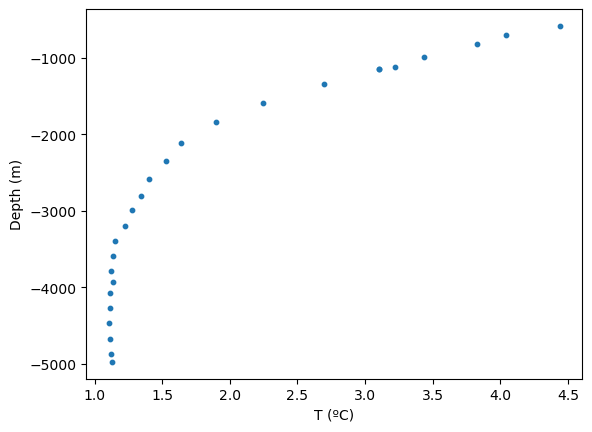

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation. 

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater. 

2024-10-31 14:38:46,001 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s


Text(0, 0.5, 'Depth (m)')

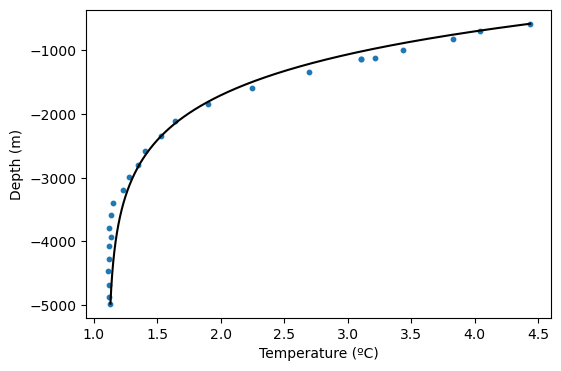

In [13]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=8.5e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water. 

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data. 

Diffusivity of about $8.5\times 10^{-5}$ gives a relatively good fit, but it seems that we cannot perfectly model these data with the assumption of one diffusivity, instead, a lower diffusivity seems to match better at deep depths, and higher value of kappa at shallow depths. This may be because of the relationship between diffusivity and temperature, or due to a relationship between stratification/density differenes and turbulence which could provide a control. 

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$. 

2024-10-31 15:55:11,631 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:11,736 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:11,844 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:11,949 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:12,060 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:12,162 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:12,264 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:12,367 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:12,484 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+00/s


2024-10-31 15:55:12,592 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:12,692 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:12,791 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:12,985 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+00/s


2024-10-31 15:55:13,170 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+00/s


2024-10-31 15:55:13,351 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:13,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:13,709 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-10-31 15:55:13,884 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-10-31 15:55:14,064 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:14,237 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+00/s


2024-10-31 15:55:14,410 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+00/s


2024-10-31 15:55:14,586 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-10-31 15:55:14,758 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+00/s


2024-10-31 15:55:14,934 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-10-31 15:55:15,145 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:15,343 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:15,545 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:15,753 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+00/s


2024-10-31 15:55:15,954 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:16,110 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+00/s


2024-10-31 15:55:16,320 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-10-31 15:55:16,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-10-31 15:55:16,753 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:16,968 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:17,184 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:17,392 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+00/s


2024-10-31 15:55:17,630 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:17,851 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:18,081 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:18,302 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:18,534 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:18,755 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:18,970 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:19,198 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:19,417 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:19,647 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:19,861 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:20,081 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:20,304 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:20,522 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:20,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:20,963 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:21,189 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:21,409 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:21,635 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:21,860 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:22,093 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:22,315 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:22,545 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:22,767 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:22,952 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


2024-10-31 15:55:23,137 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+00/s


2024-10-31 15:55:23,321 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+00/s


2024-10-31 15:55:23,507 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+00/s


2024-10-31 15:55:23,690 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:23,867 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


2024-10-31 15:55:24,050 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:24,682 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2024-10-31 15:55:24,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+00/s


2024-10-31 15:55:25,060 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s


2024-10-31 15:55:25,242 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:25,423 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:25,537 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:25,636 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:25,735 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:25,833 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:25,932 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:26,034 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:26,133 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:26,230 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:26,327 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:26,426 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:26,528 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:26,626 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:26,810 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


2024-10-31 15:55:26,992 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:27,170 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


2024-10-31 15:55:27,347 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-10-31 15:55:27,530 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+00/s


2024-10-31 15:55:27,708 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+00/s


2024-10-31 15:55:27,883 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-10-31 15:55:28,064 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:28,245 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+00/s


2024-10-31 15:55:28,429 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+00/s


2024-10-31 15:55:28,621 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s


2024-10-31 15:55:28,812 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s


2024-10-31 15:55:29,064 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2024-10-31 15:55:29,296 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:29,531 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:29,778 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


2024-10-31 15:55:30,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


2024-10-31 15:55:30,262 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:30,501 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:30,734 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:30,961 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:31,193 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:31,418 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:31,648 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:31,872 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:32,102 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:32,326 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:32,558 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:32,795 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:33,036 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2024-10-31 15:55:33,279 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2024-10-31 15:55:33,527 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


2024-10-31 15:55:33,766 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:34,002 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:34,234 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:34,461 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:34,682 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:34,882 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:35,093 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-10-31 15:55:35,294 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:35,495 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:35,695 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:35,893 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:36,098 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:36,302 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:36,501 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:36,701 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:36,906 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:37,115 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:37,313 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:37,516 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:37,708 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s


2024-10-31 15:55:37,902 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


2024-10-31 15:55:38,093 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s


2024-10-31 15:55:38,287 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+00/s


2024-10-31 15:55:38,494 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+00/s


2024-10-31 15:55:38,690 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:38,882 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+00/s


2024-10-31 15:55:39,086 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:39,284 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:39,400 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:39,512 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


2024-10-31 15:55:39,620 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:39,724 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:39,827 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:39,930 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:40,439 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2024-10-31 15:55:40,550 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


2024-10-31 15:55:40,657 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:40,757 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:40,857 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:40,957 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:41,176 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-10-31 15:55:41,376 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:41,590 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:41,789 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:41,994 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:42,198 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:42,396 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:42,609 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-10-31 15:55:42,810 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:43,013 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:43,214 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:43,414 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:43,650 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:43,873 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:44,106 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:44,329 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:44,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:44,783 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:45,004 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:45,234 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:45,455 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:45,684 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:45,903 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:46,129 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:46,356 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:46,584 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:46,803 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:47,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:47,245 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:47,465 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:47,689 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:47,907 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:48,129 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:48,348 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:48,569 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:48,787 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:49,015 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:49,235 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:49,453 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:49,675 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:49,893 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:50,131 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-10-31 15:55:50,365 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:50,610 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2024-10-31 15:55:50,823 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2024-10-31 15:55:51,046 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:51,269 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:51,492 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:51,702 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:51,899 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:52,101 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:52,298 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:52,496 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:52,697 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:52,895 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:53,097 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+00/s


2024-10-31 15:55:53,294 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:53,491 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2024-10-31 15:55:53,692 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:53,891 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+00/s


2024-10-31 15:55:53,997 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,096 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,191 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,286 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,382 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,481 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,581 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,678 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,773 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,869 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:54,966 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:55:55,066 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-10-31 15:55:55,293 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:55,517 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:55,741 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:55,961 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:56,187 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:56,407 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:56,635 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:56,856 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:57,081 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:57,302 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:57,526 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:58,189 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


2024-10-31 15:55:58,415 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:58,648 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:55:58,868 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:59,094 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:55:59,314 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:59,538 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:55:59,758 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:55:59,978 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:00,209 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:56:00,426 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:00,656 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:56:00,876 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:01,112 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:56:01,331 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:01,558 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:01,784 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:02,007 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:02,230 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:02,451 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:02,682 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.6e+00/s


2024-10-31 15:56:02,903 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:03,130 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:03,352 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:03,579 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:03,808 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:04,032 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:04,250 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:04,469 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:04,695 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:04,915 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:05,140 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:05,360 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:05,584 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:05,805 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:06,027 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:06,247 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:06,472 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:06,698 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:06,915 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:07,140 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:07,358 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:07,581 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:07,801 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:08,025 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:08,248 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2024-10-31 15:56:08,467 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:08,693 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-10-31 15:56:08,911 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-10-31 15:56:09,018 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,117 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,211 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,306 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,400 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,495 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,595 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,690 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,785 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,880 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:09,975 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-10-31 15:56:10,075 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


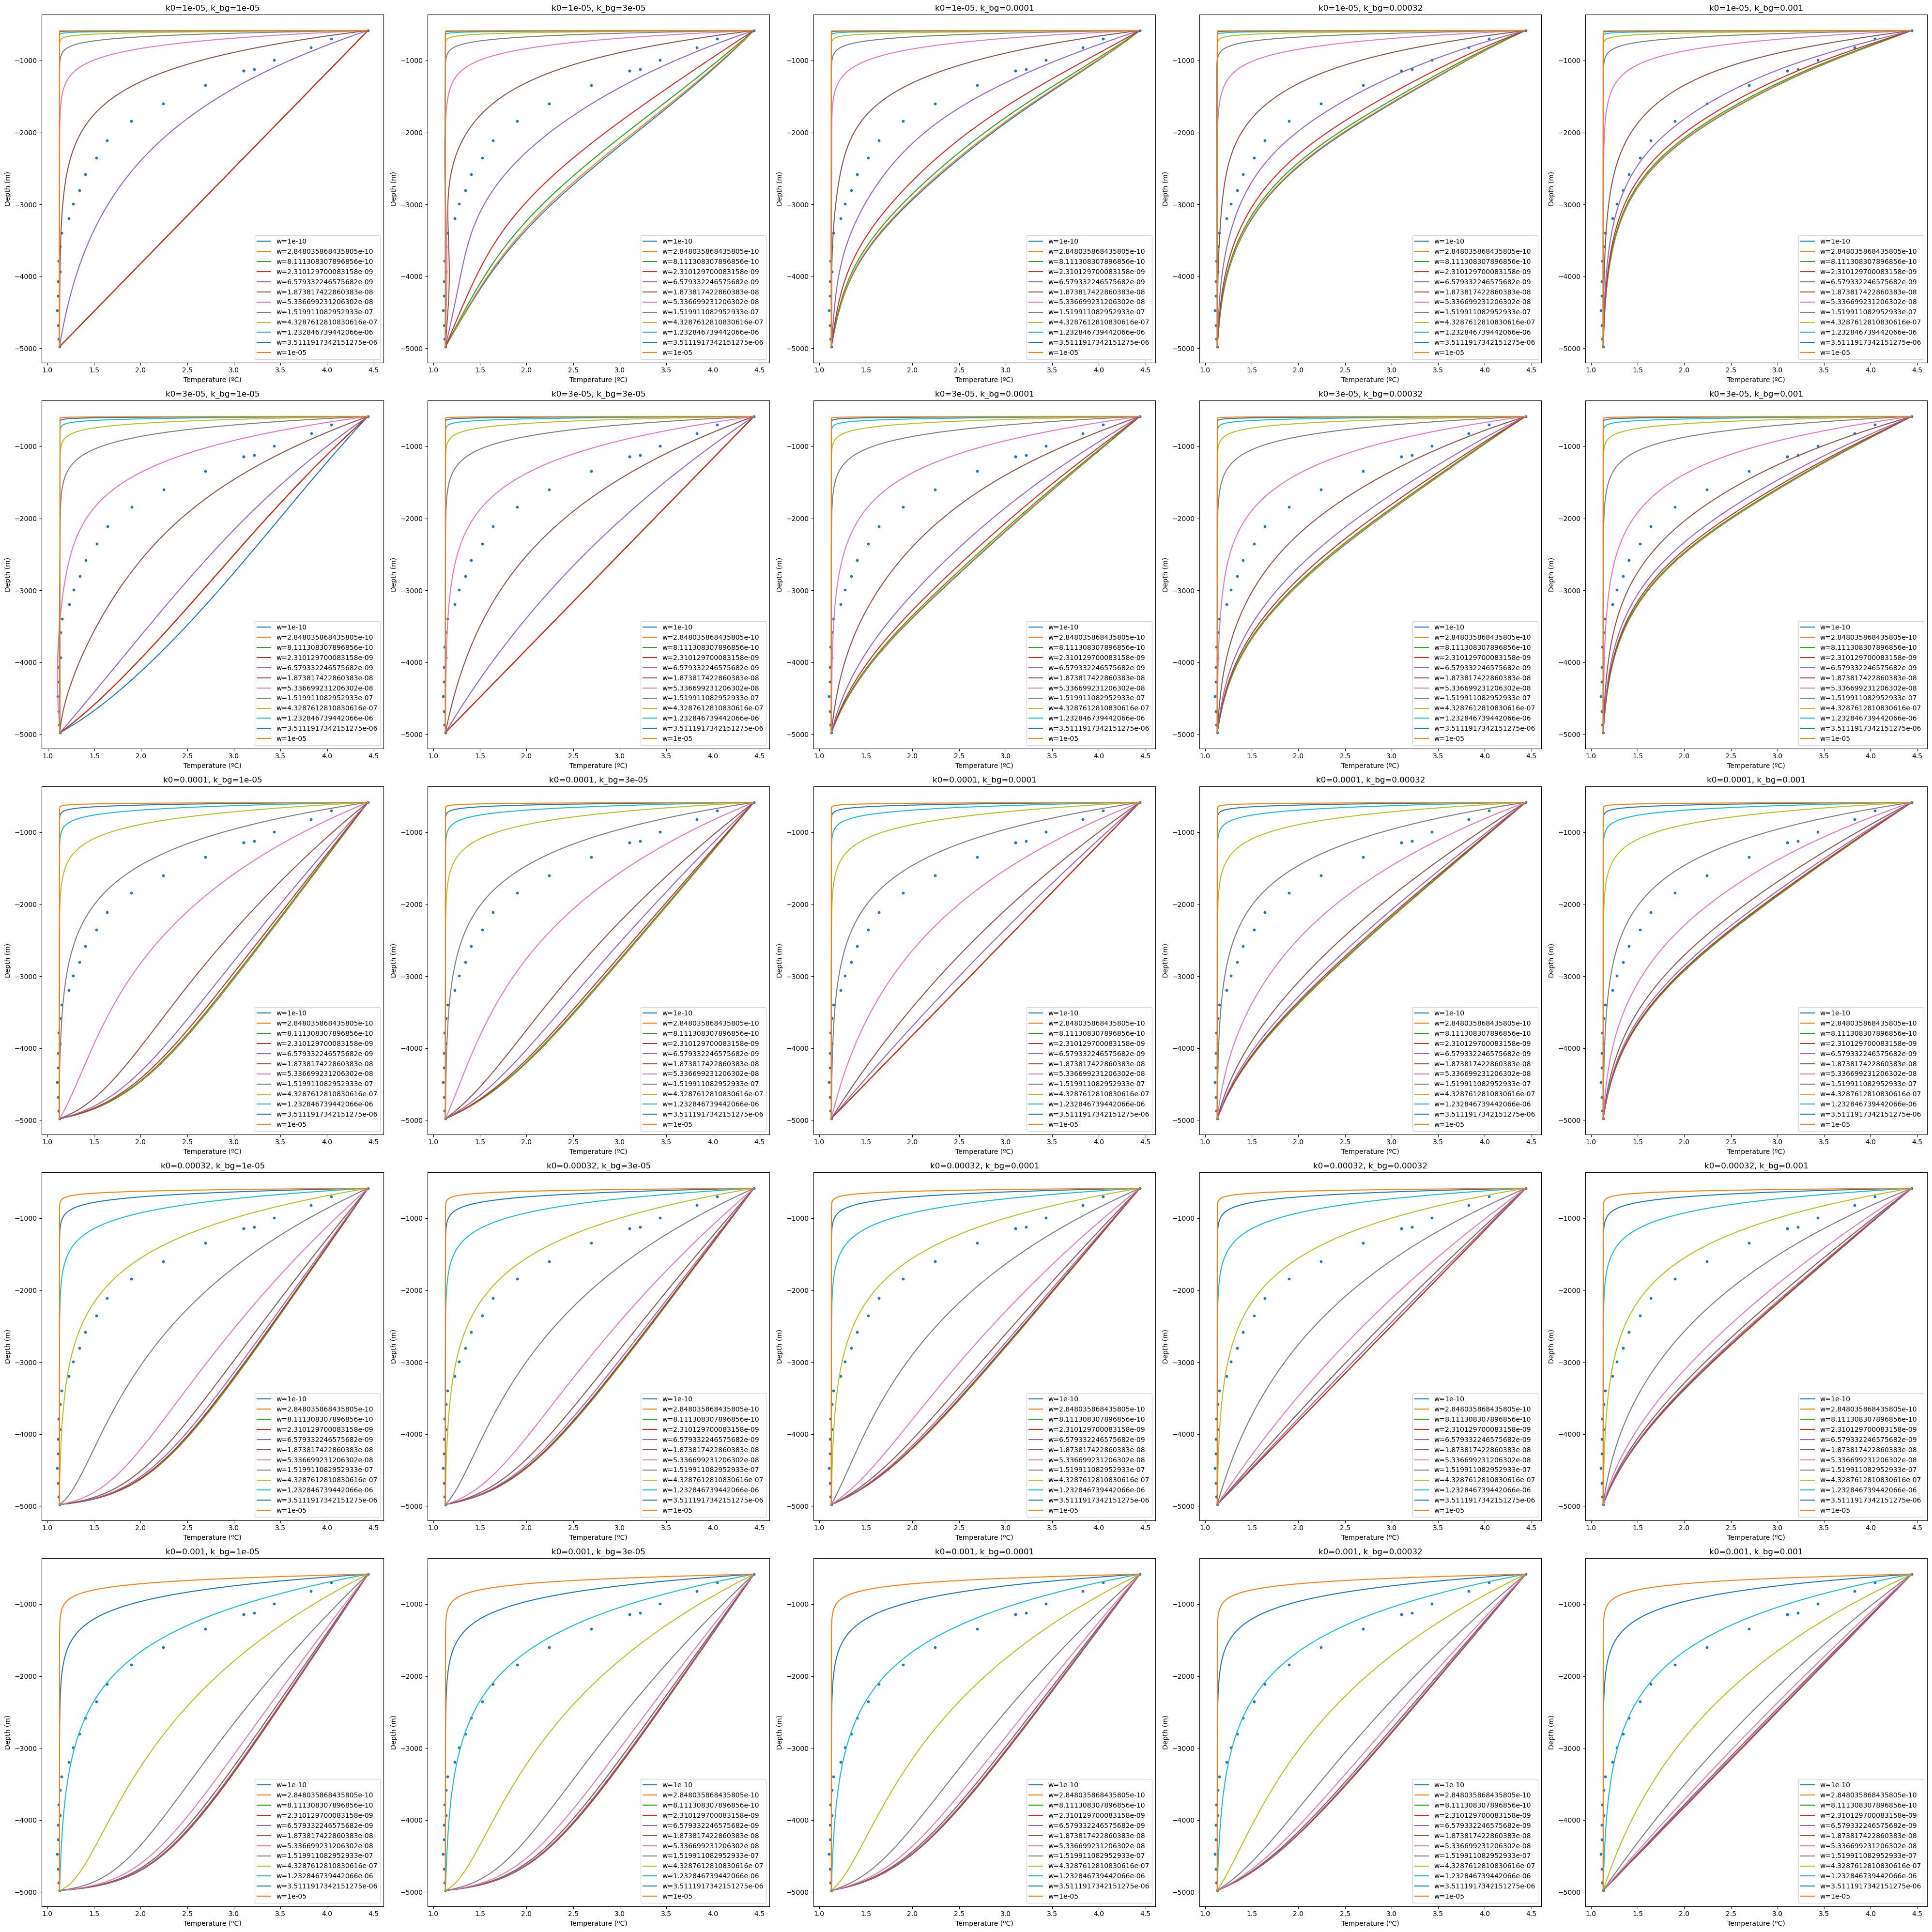

In [38]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

w_intervals = 12
w_start = 1e-10
w_end = 1e-5

k0_intervals = 5
k0_start = 1e-5
k0_end = 1e-3

k_bg_intervals = 5
k_bg_start = 1e-5
k_bg_end = 1e-3

fig, axs = plt.subplots(nrows=k0_intervals,ncols=k_bg_intervals, figsize=(40,40))
for row,k0 in enumerate(np.logspace(np.log10(k0_start),np.log10(k0_end),k0_intervals)):
    for col,k_bg in enumerate(np.logspace(np.log10(k_bg_start),np.log10(k_bg_end),k_bg_intervals)):
        axs[row,col].set_title('k0='+str(round(k0,5))+', k_bg='+str(round(k_bg,5)))
        plt.sca(axs[row,col])
        for index,w in enumerate(np.logspace(np.log10(w_start),np.log10(w_end),w_intervals)):
# Set various parameters. Note that the depth and the top and bottom temperature 
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
            z_surface = CTD_z[-1]
            z_bottom = CTD_z[0]
            T_surface = CTD_T[-1]
            T_bottom = CTD_T[0]
            Nz = 1000

# Set the vertical velocity

# Bases
            zcoord = d3.Coordinate('z')
            dist = d3.Distributor(zcoord, dtype=np.float64)
            zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
            z = dist.local_grid(zbasis)

# Fields
            T = dist.Field(name='T', bases=zbasis)
            kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
            kappa['g']= k0 + (k_bg-k0)*np.exp((-5e3-z)/667) # m^2/s
            # kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
            tau_1 = dist.Field(name='tau_1')
            tau_2 = dist.Field(name='tau_2')
            lift_basis = zbasis.derivative_basis(1)
            lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
            dz = lambda A: d3.Differentiate(A, zcoord)
            Tz = dz(T) + lift(tau_1)
            Tzz = dz(Tz) + lift(tau_2)

# Problem
            problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
            problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
            problem.add_equation("T(z=z_surface) = T_surface")
            problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
            solver = problem.build_solver()
            solver.solve()

# Plot
            Tg=T['g']
            plt.plot(Tg,z,label='w='+str(w))
        plt.scatter(CTD_T,CTD_z,s=10)
        plt.xlabel('Temperature (ºC)')
        plt.ylabel('Depth (m)')
        plt.legend() 
plt.tight_layout()
plt.savefig('transport.png')


### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

$w=10^{-8}$ is a better fit with the observations. The optimal value of $w$ is more sensitive to the choice of $\kappa_0$ than to $\kappa_{bg}$, though their is some sensitivity to both. $\kappa_0$ is the bottom diffusivity, so it implies that if $\kappa$ varies between topography, it means we set up a gradient in upwelling velocity to drive some ciruclation. Intuitively, it makes sense that a rough surface would induce more diffusion, so a higher bottom diffusivity which increases velocity and drives more turbulence and mixing in the rough areas.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as 

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [5]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])]; 

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

2024-10-31 14:29:09,134 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+00/s


2024-10-31 14:29:09,136 __main__ 0/1 INFO :: Starting main loop


2024-10-31 14:29:09,719 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-10-31 14:29:09,734 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-10-31 14:29:09,748 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-10-31 14:29:09,762 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-10-31 14:29:09,776 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-10-31 14:29:09,791 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-10-31 14:29:09,805 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-10-31 14:29:09,819 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-10-31 14:29:09,833 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-10-31 14:29:09,847 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-10-31 14:29:09,862 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-10-31 14:29:09,876 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-10-31 14:29:09,890 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-10-31 14:29:09,906 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-10-31 14:29:09,921 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-10-31 14:29:09,935 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-10-31 14:29:09,950 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-10-31 14:29:09,964 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-10-31 14:29:09,979 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-10-31 14:29:09,993 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-10-31 14:29:10,008 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-10-31 14:29:10,023 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-10-31 14:29:10,037 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-10-31 14:29:10,052 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-10-31 14:29:10,067 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-10-31 14:29:10,082 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-10-31 14:29:10,096 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-10-31 14:29:10,111 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-10-31 14:29:10,125 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-10-31 14:29:10,139 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-10-31 14:29:10,154 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-10-31 14:29:10,169 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-10-31 14:29:10,183 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-10-31 14:29:10,198 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-10-31 14:29:10,212 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-10-31 14:29:10,226 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-10-31 14:29:10,241 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-10-31 14:29:10,255 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-10-31 14:29:10,270 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-10-31 14:29:10,284 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-10-31 14:29:10,299 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-10-31 14:29:10,313 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-10-31 14:29:10,328 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-10-31 14:29:10,342 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-10-31 14:29:10,357 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-10-31 14:29:10,371 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-10-31 14:29:10,385 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-10-31 14:29:10,400 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-10-31 14:29:10,414 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-10-31 14:29:10,428 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-10-31 14:29:10,443 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-10-31 14:29:10,458 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-10-31 14:29:10,472 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-10-31 14:29:10,487 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-10-31 14:29:10,501 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-10-31 14:29:10,515 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-10-31 14:29:10,530 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-10-31 14:29:10,545 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-10-31 14:29:10,559 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-10-31 14:29:10,574 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-10-31 14:29:10,589 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-10-31 14:29:10,603 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-10-31 14:29:10,617 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-10-31 14:29:10,631 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-10-31 14:29:10,646 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-10-31 14:29:10,660 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-10-31 14:29:10,674 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-10-31 14:29:10,688 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-10-31 14:29:10,702 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-10-31 14:29:10,716 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-10-31 14:29:10,731 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-10-31 14:29:10,745 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-10-31 14:29:10,759 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-10-31 14:29:10,773 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-10-31 14:29:10,787 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-10-31 14:29:10,802 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-10-31 14:29:10,816 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-10-31 14:29:10,826 solvers 0/1 INFO :: Simulation stop time reached.


2024-10-31 14:29:10,826 solvers 0/1 INFO :: Final iteration: 768


2024-10-31 14:29:10,826 solvers 0/1 INFO :: Final sim time: 1500.0


2024-10-31 14:29:10,827 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7904 sec


2024-10-31 14:29:10,827 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.03422 sec


2024-10-31 14:29:10,827 solvers 0/1 INFO :: Run time (iter 10-end): 1.094 sec


2024-10-31 14:29:10,828 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0003038 cpu-hr


2024-10-31 14:29:10,828 solvers 0/1 INFO :: Speed: 1.202e+07 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command: 

`conda install -c conda-forge ffmpeg`

2024-10-31 14:29:10,903 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-10-31 14:29:10,903 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkdvw3qd7/temp.m4v


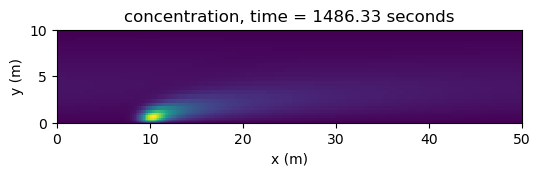

In [6]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))  

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)   
    plt.ylim(0, w)  
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

From the reference frame of the tracer moving along the river, we can assume advection is 0. The terms then scale as below:
$$ \frac{1}{t} \sim \frac{\kappa}{w^2} $$ 
Therefore, the time to reach the other side of the river is $t \sim w^2/\kappa$. The distance downstream is then $x \sim U_0 t \sim U_0 w^2/\kappa$. Subsituting our values gives a characteristic downstream distance of $1000\mathrm{m}$, which is probably an upperbound as $u \leq U_0$ across the river. 

[0, 5, 10, 15, 20, 25, 30]


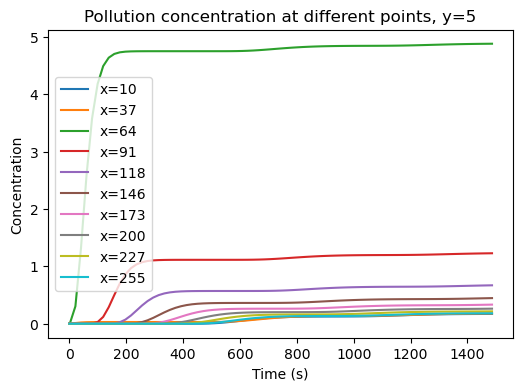

In [54]:
x_points = np.linspace(10,255,10,dtype=int)
print(y_points)
c_points = np.zeros((len(x_points), len(t_save)))
for i in range(len(x_points)):
    c_points[i,:] = c_save[:,x_points[i],5]

plt.figure(figsize=(6,4))
for i in range(len(x_points)):
    plt.plot(t_save,c_points[i,:],label='x='+str(x_points[i]))
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution concentration at different points, y=5')
plt.legend()


## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.